In [1]:
%matplotlib inline
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from scipy import stats, signal
from dtw import dtw
from termcolor import colored
import itertools
import tslearn.barycenters

In [2]:
plot_3d_anim = False

signal = { 'acc': { 'x': [], 'y': [], 'z': [], 'mag': [] }, 'q': { 'x': [], 'y': [], 'z': [], 'mag': [] } }

GESTURE_LIST = ["pick", "putback", "norotateputback"]
TEMPLATE_NUM = 3

gesture_template_dict = {}
for g in GESTURE_LIST:
    gesture_template_dict[g] = {}
    for i in range(1,TEMPLATE_NUM+1):
        gesture_template_dict[g][i] = {}

DATA_TYPE = ["acc", "q"]

signal_data_path = "../real_data/SensorFusion_07_14_2021-18_30_03.csv"

motion_index_list = []
GESTURE_LABEL_LIST = ["pick", "putback", "other"]
gesture_label_dict = {}
for g in GESTURE_LABEL_LIST:
    gesture_label_dict[g] = set()

In [3]:
def read_acc_comparison_data():
    df = pd.read_csv(signal_data_path)
    for index, row in df.iterrows():
        data_type, w, x, y, z = df['type'][index], df['w'][index], df['x'][index], df['y'][index], df['z'][index]
        if data_type == 'a':
            if len(signal["q"]['x']) > len(signal["acc"]['x']):  # to make sure one q match one a
                signal["acc"]['x'].append(x)
                signal["acc"]['y'].append(y)
                signal["acc"]['z'].append(z)
                signal["acc"]['mag'].append(w)
        if data_type == 'q':
            signal["q"]['x'].append(x)
            signal["q"]['y'].append(y)
            signal["q"]['z'].append(z)
            signal["q"]['mag'].append(w)
        if data_type == 'm':
            motion_index_list.append(int(w))
        if data_type == 'l':
            data = w.split("-")
            gesture, time = data[0], int(data[1])
            gesture_label_dict[gesture].add(time)

    for gesture in GESTURE_LIST:
        for data_index in range(1,TEMPLATE_NUM+1):
#             print(gesture, data_index)
            data_path = "../template_data/SensorFusion_template_%s%d.csv" % (gesture, data_index)
            df = pd.read_csv(data_path)
            gesture_template_dict[gesture][data_index] = { 'acc': { 'x': [], 'y': [], 'z': [], 'mag': [] }, 'q': { 'x': [], 'y': [], 'z': [], 'mag': [] } }
            for index, row in df.iterrows():
                data_type, w, x, y, z = df['type'][index], float(df['w'][index]), float(df['x'][index]), float(df['y'][index]), float(df['z'][index])
                if data_type == 'a':
                    if len(gesture_template_dict[gesture][data_index]['q']['x']) > len(gesture_template_dict[gesture][data_index]['acc']['x']):  # to make sure one q match one a
                        gesture_template_dict[gesture][data_index]['acc']['x'].append(x)
                        gesture_template_dict[gesture][data_index]['acc']['y'].append(y)
                        gesture_template_dict[gesture][data_index]['acc']['z'].append(z)
                        gesture_template_dict[gesture][data_index]['acc']['mag'].append(w)
                if data_type == 'q':
                    gesture_template_dict[gesture][data_index]['q']['x'].append(x)
                    gesture_template_dict[gesture][data_index]['q']['y'].append(y)
                    gesture_template_dict[gesture][data_index]['q']['z'].append(z)
                    gesture_template_dict[gesture][data_index]['q']['mag'].append(w)

read_acc_comparison_data()

In [4]:
# [Region] merge multiple templates to one
z_norm_time_series = {}
merged_z_norm_templates = {}

# init
for g in GESTURE_LIST:
    z_norm_time_series[g] = { 'acc': { 'x': [], 'y': [], 'z': [], 'mag': [] }, 'q': { 'x': [], 'y': [], 'z': [], 'mag': [] } }  # []: list of lists (2D)
    merged_z_norm_templates[g] = { 'acc': { 'x': [], 'y': [], 'z': [], 'mag': [] }, 'q': { 'x': [], 'y': [], 'z': [], 'mag': [] } }  # []: list (1D)

for gesture in GESTURE_LIST:
    for template_index in range(1,TEMPLATE_NUM+1):
        for d_type in DATA_TYPE:
            for key in ['x', 'y', 'z', 'mag']:
                z_norm_template = stats.zscore(gesture_template_dict[gesture][template_index][d_type][key])
                z_norm_time_series[gesture][d_type][key].append(z_norm_template)

for gesture in GESTURE_LIST:
    for d_type in DATA_TYPE:
        for key in ['x', 'y', 'z', 'mag']:
            merged_z_norm_templates[gesture][d_type][key] = np.array(tslearn.barycenters.dtw_barycenter_averaging(z_norm_time_series[gesture][d_type][key], barycenter_size=30)).flatten()
# [EndRegion]


In [5]:
# [Region] calculate template distance
templates_distance = {}
for g in GESTURE_LIST:
    templates_distance[g] = { 'acc': { 'x': [], 'y': [], 'z': [], 'mag': [] }, 'q': { 'x': [], 'y': [], 'z': [], 'mag': [] } }  # []: list of float (distance)

# for g in GESTURE_LIST:
#     for d_type in DATA_TYPE:
#         for key, z_norm_merged_template in merged_z_norm_templates[g][d_type].items():
#             for index in range(TEMPLATE_NUM):
#                 z_norm_template = z_norm_time_series[g][d_type][key][index]
#                 x = np.array(z_norm_merged_template).reshape(-1, 1)
#                 y = np.array(z_norm_template).reshape(-1, 1)
#                 manhattan_distance = lambda x, y: np.abs(x - y)
#                 d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=manhattan_distance)
#                 templates_distance[g][d_type][key].append(d)

all_combinations = list(itertools.combinations(list(range(1,TEMPLATE_NUM+1)), 2))
for gesture in GESTURE_LIST:
    for template_index_pair in all_combinations:
        for d_type in DATA_TYPE:
            for key in ['x', 'y', 'z', 'mag']:
                template_index1 = template_index_pair[0]
                template_index2 = template_index_pair[1]
                z_norm_template_signal1 = stats.zscore(gesture_template_dict[gesture][template_index1][d_type][key])
                z_norm_template_signal2 = stats.zscore(gesture_template_dict[gesture][template_index2][d_type][key])
                x = np.array(z_norm_template_signal1).reshape(-1, 1)
                y = np.array(z_norm_template_signal2).reshape(-1, 1)
                manhattan_distance = lambda x, y: np.abs(x - y)
                d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=manhattan_distance)
                templates_distance[gesture][d_type][key].append(d)
# [EndRegion]

In [6]:
# [Region] remove outlier and calculate distance threshold
distance_threshold = {}
for g in GESTURE_LIST:
    distance_threshold[g] = { 'acc': { 'x': {}, 'y': {}, 'z': {}, 'mag': {} }, 'q': { 'x': {}, 'y': {}, 'z': {}, 'mag': {} } }  # {}: min value, max value

MIN_MATCH_LEN = {}
for g in GESTURE_LIST:
    MIN_MATCH_LEN[g] = 2
    
# tmp_templates_distance = dict(templates_distance)
# # remove outlier 
# for g in GESTURE_LIST:
#     for d_type in DATA_TYPE:
#         for t_key, t_value in tmp_templates_distance[g][d_type].items():
#             np_t_value = np.array(t_value)
#             mean = np.mean(np_t_value)
#             std = np.std(np_t_value)
#             distance_from_mean = abs(np_t_value - mean)
#             max_deviations = 1
#             not_outlier = distance_from_mean < max_deviations * std
#             no_outliers = np_t_value[not_outlier]
#             templates_distance[g][d_type][t_key] = no_outliers

for g in GESTURE_LIST:
    for d_type in DATA_TYPE:
        for t_key, t_value in templates_distance[g][d_type].items():
            mean = np.mean(t_value)
            std = np.std(t_value)
            distance_threshold[g][d_type][t_key]["min"] = 0 
            distance_threshold[g][d_type][t_key]["max"] = mean
            if mean <= 20:
                distance_threshold[g][d_type][t_key]["max"] += std
#             if mean >= 60:
#                 MIN_MATCH_LEN[g] = 3
            print("after mean: %f, std: %f" % (mean, std)) 
            print("gesture: %s, key: %s, %s template min distance: %f, max distance: %f" % (g, t_key, d_type, distance_threshold[g][d_type][t_key]["min"], distance_threshold[g][d_type][t_key]["max"]))
# [EndRegion]

after mean: 35.469315, std: 5.105427
gesture: pick, key: x, acc template min distance: 0.000000, max distance: 35.469315
after mean: 20.395291, std: 5.095171
gesture: pick, key: y, acc template min distance: 0.000000, max distance: 20.395291
after mean: 29.900912, std: 6.867734
gesture: pick, key: z, acc template min distance: 0.000000, max distance: 29.900912
after mean: 40.500326, std: 4.437595
gesture: pick, key: mag, acc template min distance: 0.000000, max distance: 40.500326
after mean: 8.495095, std: 3.882127
gesture: pick, key: x, q template min distance: 0.000000, max distance: 12.377222
after mean: 12.376259, std: 3.949900
gesture: pick, key: y, q template min distance: 0.000000, max distance: 16.326159
after mean: 18.952849, std: 5.341145
gesture: pick, key: z, q template min distance: 0.000000, max distance: 24.293994
after mean: 10.835110, std: 4.735466
gesture: pick, key: mag, q template min distance: 0.000000, max distance: 15.570575
after mean: 43.586382, std: 13.797854

In [7]:
def quaternion_to_moving_direction_str(key, q_value_part):
    slope = (q_value_part[-1] - q_value_part[0]) / sequence_length
    if abs(slope) <= 0.001:
        slope = 0.0
        return "無"

    if key == "x":
        if slope > 0:
            return "往上"
        elif slope < 0:
            return "往下"
    elif key == "y":
        if slope > 0:
            return "手腕右旋"
        elif slope < 0:
            return "手腕左旋"
    elif key == "z":
        if slope > 0:
            return "手臂轉外"
        elif slope < 0:
            return "手臂轉內"
    else:
        raise KeyError("No such key %s, can be either x, y or z" % (key))

### putback ground truth

pick
putback
FP
pick
putback
FP
pick
putback
FP
pick
putback
FP


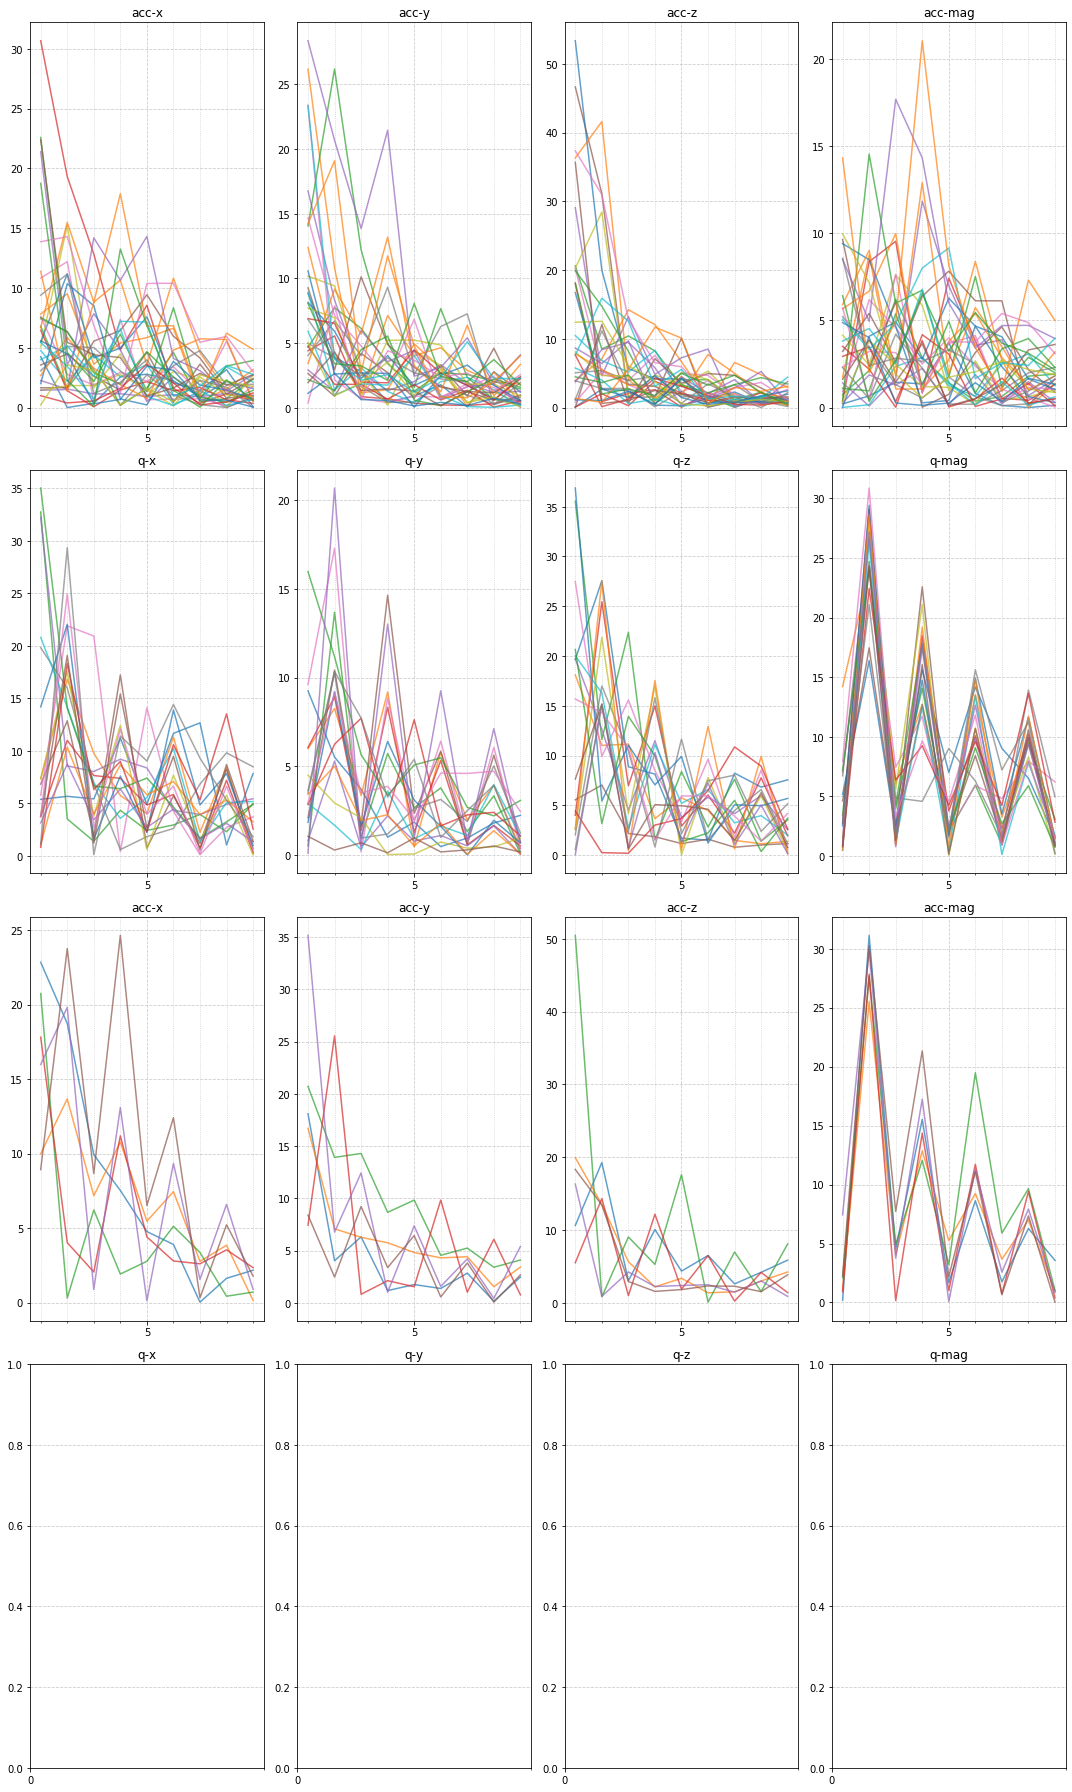

In [8]:
from scipy.fftpack import rfft, rfftfreq, dct, fft, fftfreq, dst, hilbert
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from scipy.stats import entropy
SAMPLE_RATE = 60
DURATION = 1
N = SAMPLE_RATE * DURATION

# We'll make a 1x4 grid of plots, so pass 1,4 to subplots
pick_interest_list = list(gesture_label_dict['pick'])
putback_interest_list = list(gesture_label_dict['putback'])
interest_list = [1050, 3090, 6510, 6960, 18315, 20730]
DATA_TYPE = ['acc', 'q']
fig, axes = plt.subplots(4, 4, figsize=(15, 25)) #figsize is width, height

gesture_detection_dict = {}  # key: start and end index, value: time for match distance threshold range
moving_direction_dict = {'x': {}, 'y': {}, 'z': {}, 'mag': {}} 
for grid_index, d_type in enumerate(DATA_TYPE):
    for index, (key, value) in enumerate(signal[d_type].items()):
#         if key == "mag":
#             continue
        axes[grid_index][index].xaxis.set_major_locator(MultipleLocator(5))
        axes[grid_index][index].xaxis.set_minor_locator(AutoMinorLocator(5))
        axes[grid_index][index].grid(which='major', color='#CCCCCC', linestyle='--')
        axes[grid_index][index].grid(which='minor', color='#CCCCCC', linestyle=':')
        axes[grid_index][index].set_title(d_type + '-' + key)
        axes[grid_index+2][index].xaxis.set_major_locator(MultipleLocator(5))
        axes[grid_index+2][index].xaxis.set_minor_locator(AutoMinorLocator(5))
        axes[grid_index+2][index].grid(which='major', color='#CCCCCC', linestyle='--')
        axes[grid_index+2][index].grid(which='minor', color='#CCCCCC', linestyle=':')
        axes[grid_index+2][index].set_title(d_type + '-' + key)
        fig.tight_layout()
#         axes[grid_index][index].plot(signal[d_type][key], alpha=0.7, label="raw_acc %s" % (key))  

#         z_norm_original_signal = []
#         sequence_length = 60
#         step = 5  # overlap = sequence_length - step
#         print(d_type, key)
#         print("-----")
#         target_g = "pick"
#         gesture_label_list = list(gesture_label_dict[target_g])
#         for i in range(0, len(value)-sequence_length, step):
#             if i in interest_list:
#                 start_index = max(i, 0)
#                 end_index = i + sequence_length
#                 value_part = np.array(value[start_index: end_index])
#                 z_score = value_part
# #                 z_score = stats.zscore(value_part)
#                 axes[grid_index][index].plot(z_score, c=color, alpha=0.7, label="z zorm template acc %s" % ("1"))
#                 start_index = max(pick_interest_list[list_index], 0)
#                 end_index = pick_interest_list[list_index] + 50
#                 pick_value_part = np.array(value[start_index: end_index])
# #                 if color == 'r':
# #                     color = 'b'
# #                 else:
#                 color = 'r'
#                 axes[2+grid_index+2*(list_index)][index].plot(pick_value_part, c=color, alpha=0.7, label="z zorm template acc %s" % ("1"))
            
            
#         for target_g in GESTURE_LIST:
#             z_norm_template_signal = merged_z_norm_templates[target_g][d_type][key]
#             for i in range(0, len(value)-sequence_length, step):
#                 start_index = i
#                 end_index = min(i+sequence_length, len(value))
#                 time_index = str(start_index) + "-" + str(end_index)

#                 value_part = value[start_index: end_index]
#                 if d_type == "q":
#                     moving_direction_dict[key][time_index] = quaternion_to_moving_direction_str(key, value_part)

#                 z_score = stats.zscore(value_part)
#                 x = np.array(z_score).reshape(-1, 1)
#                 y = np.array(z_norm_template_signal).reshape(-1, 1)
#                 manhattan_distance = lambda x, y: np.abs(x - y)
#                 d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=manhattan_distance)
#     #             if i == 0 or i == 270:  # for grasp
#     #             if i == 130 or i == 400:  # for release
#     #                 if i == 0 or i == 130:
#     #                     color = 'r'
#     #                 else:
#     #                     color = 'g'
#     #                 axes[grid_index][index].plot(z_score, color, alpha=0.7, label="z zorm template acc %s" % ("1"))
#     #                 print(d)
# #                 print("index: %d - %d: distance: %f" % (start_index, end_index, d))
#                 if key != "mag":
#                     if distance_threshold[target_g][d_type][key]["min"] <= d and d <= distance_threshold[target_g][d_type][key]["max"]:
# #                         print("gesture: %s, key: %s, index: %d - %d: distance: %f" % (target_g, key, start_index, end_index, d))
#     #                     print(colored("type: %s, key: %s, index: %d - %d: distance: %f" % (d_type, key, start_index, end_index, d), 'green'))
#                         dict_key = target_g + "-" + str(start_index) + "-" + str(end_index)
#                         if dict_key in gesture_detection_dict:
#                             gesture_detection_dict[dict_key].append(d_type + '-' + key)
#                         else:
#                             gesture_detection_dict[dict_key] = [d_type + '-' + key]
#     #                 else:
#     #                     print(colored("type: %s, key: %s, index: %d - %d: distance: %f" % (d_type, key, start_index, end_index, d), 'red'))

#         for i, _g in enumerate(["norotateputback"]):
#             axes[grid_index][index].plot(gesture_template_dict[_g][1][d_type][key], 'r', alpha=0.7, label="z zorm template acc %s" % ("1"))
#             axes[grid_index][index].plot(gesture_template_dict[_g][2][d_type][key], 'g', alpha=0.7, label="z zorm template acc %s" % ("1"))
#             axes[grid_index][index].plot(gesture_template_dict[_g][3][d_type][key], 'b', alpha=0.7, label="z zorm template acc %s" % ("1"))

#             axes[grid_index][index].plot(merged_z_norm_templates[_g][d_type][key], 'k', alpha=0.7, label="z zorm template acc %s" % ("1"))

#         axes[grid_index][index].plot(gesture_template_dict['pick'][1][d_type][key], 'r', alpha=0.7, label="z zorm template acc %s" % ("1"))
#         axes[grid_index][index].plot(gesture_template_dict['pick'][2][d_type][key], 'g', alpha=0.7, label="z zorm template acc %s" % ("1"))
#         axes[grid_index][index].plot(gesture_template_dict['pick'][3][d_type][key], 'b', alpha=0.7, label="z zorm template acc %s" % ("1"))
#         axes[grid_index][index].plot(gesture_template_dict['pick'][4][d_type][key], 'c', alpha=0.7, label="z zorm template acc %s" % ("1"))
#         axes[grid_index][index].plot(gesture_template_dict['pick'][5][d_type][key], 'm', alpha=0.7, label="z zorm template acc %s" % ("1"))
#         test_list = []
#         for i in range(1, TEMPLATE_NUM+1):
#             value_part1 = np.array(gesture_template_dict['putback'][i][d_type][key])
#             test_list.append(value_part1)
#         test_array = np.array(tslearn.barycenters.dtw_barycenter_averaging(test_list, barycenter_size=50)).flatten()
#         test_array = (test_array - test_array.min())/(test_array.max() - test_array.min())
#         axes[grid_index][index].plot(test_array, 'k', alpha=0.7, label="z zorm template acc %s" % ("1"))


        if d_type == 'q':
            continue
        print('pick')
        for pick_interest in pick_interest_list:
            start_index = max(pick_interest, 0)
            end_index = pick_interest + 60
            value_part = np.array(value[start_index: end_index])
#             axes[grid_index][index].plot(value_part, alpha=0.7, label="z zorm template acc %s" % ("1"))
            yf = dct(value_part) # dct的acc, 跟rfft的acc_mag好像有一點差別
#             print(len(yf))
            xf = fftfreq(N, 1 / SAMPLE_RATE)
#             print(xf)
            yf = np.abs(yf[1:10])
            xf = np.abs(xf[1:10])
#             print(yf.std())
#             print(len(find_peaks(yf, threshold=5)[0]))
            axes[grid_index][index].plot(xf, np.abs(yf), alpha=0.7, label="z zorm template acc %s" % ("1"))
    
        print('putback')
        for putback_interest in putback_interest_list:
            start_index = max(putback_interest - 60, 0)
            end_index = putback_interest
            value_part = np.array(value[start_index: end_index])
#             axes[grid_index+1][index].plot(value_part, alpha=0.7, label="z zorm template acc %s" % ("1"))
            yf = dst(value_part)
            xf = fftfreq(N, 1 / SAMPLE_RATE)
            yf = np.abs(yf[1:10])
            xf = np.abs(xf[1:10])
#             fhat = np.fft.fft(value_part, N)
#             PSD = fhat * np.conj(fhat) / N
#             yf = np.abs(PSD[1:10])
#             print(yf.max())
#             print(yf.mean())
#             print(len(find_peaks(yf)[0]))
#             print(stats.skew(yf))
#             print(np.sum(yf > yf.mean()))
            axes[grid_index+1][index].plot(xf, np.abs(yf), alpha=0.7, label="z zorm template acc %s" % ("1"))
            
        print('FP')
        for i, putback_interest in enumerate(interest_list):
            start_index = max(putback_interest, 0)
            end_index = putback_interest + 60
            value_part = np.array(value[start_index: end_index])
#             axes[grid_index+2][index].plot(value_part, alpha=0.7, label="z zorm template acc %s" % ("1"))
            yf = dst(value_part)
            xf = fftfreq(N, 1 / SAMPLE_RATE)
            yf = np.abs(yf[1:10])
            xf = np.abs(xf[1:10])
#             fhat = np.fft.fft(value_part, N)
#             PSD = fhat * np.conj(fhat) / N
#             yf = np.abs(PSD[1:10])
# #             print(yf.max())
#             print(len(find_peaks(yf)[0]))
#             print(np.sum(yf > yf.mean()))
#             print(stats.skew(yf))
#             print(yf.mean())
#             if yf.max() > 10 and key == 'mag':
#                 print(start_index, end_index)
#             else:
            axes[grid_index+2][index].plot(xf, np.abs(yf), alpha=0.7, label="z zorm template acc %s" % ("1"))
            
plt.show()

moving_direction_str_dict = {}
for key, value in moving_direction_dict['x'].items():
    moving_direction_str_dict[key] = value + "," + moving_direction_dict['y'][key] + "," + moving_direction_dict['z'][key]